# Task 1 : Set up colab gpu runtime environment

In [2]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=f2d05f6e36eb82d0c9aa5e92657ab09b50e0a482ad79a3d0f192f753dfe60d6e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=a472bfc57764c8b9c15e93a83203098804b38a9a0e5d4688e8c11eb61ece136b
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [3]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 35.35 MiB/s, done.
Resolving deltas: 100% (3/3), done.


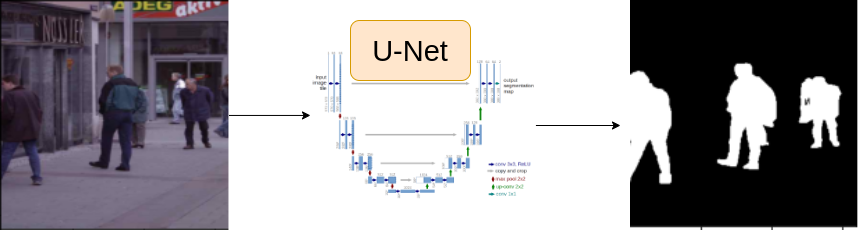

# Some Common Imports

In [4]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [5]:
print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/Human-Segmentation-Dataset-master']


In [6]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

## TPU Settings

In [ ]:
#TPU settings

# !pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

# import torch_xla
# import torch_xla.core.xla_model as xm

# import os
# assert os.environ['COLAB_TPU_ADDR']

# DEVICE = xm.xla_device()

# Task : 2 Setup Configurations

In [24]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

In [26]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content'


EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [27]:
df = pd.read_csv(CSV_FILE)
print("Dataframe size: ", df.shape[0])
df.head()

Dataframe size:  290


,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [28]:
row = df.iloc[15]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

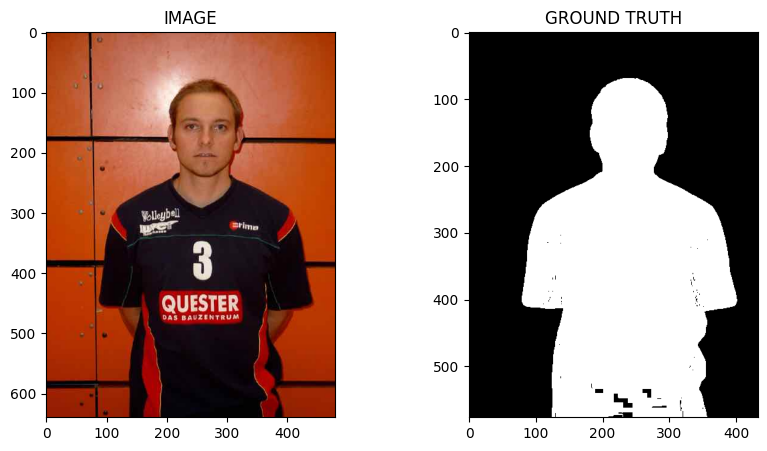

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [30]:
# I_added
anomaly_counter = 0
corrupted_idxs = []
for idx in range(df.shape[0]):
    image_size = cv2.imread(df.iloc[idx].images).shape
    mask_size = cv2.imread(df.iloc[idx].masks).shape
    if image_size != mask_size:
        anomaly_counter += 1
        corrupted_idxs.append(idx)
print(f"{anomaly_counter} number of masks don't match their corresponding images shape")

df.drop(corrupted_idxs, inplace=True)

print(f'corrupted data dropped out of dataframe, df now has {df.shape[0]} indices')
df

198 number of masks don't match their corresponding images shape
corrupted data dropped out of dataframe, df now has 92 indices


,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
5,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
6,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
...,...,...
277,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
279,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
281,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
286,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [31]:
train_df, valid_df = train_test_split (df, test_size=0.2, random_state=42)

In [32]:
idx = 50
print(cv2.imread(df.iloc[idx].images).shape)
print(cv2.imread(df.iloc[idx].masks).shape)

(162, 311, 3)
(162, 311, 3)


# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [33]:
import albumentations as A

In [34]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ]
      ,is_check_shapes=False
  )

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [35]:
from torch.utils.data import Dataset

In [36]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations


  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w)
    mask = np.expand_dims(mask, axis = -1) #(h, w, c)

    if self.augmentations:
      data = self.augmentations(image = image , mask = mask)
      image = data.get('image')
      mask = data.get('mask')

    #(h, w, c) -> (c, h, w)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    image.to(DEVICE) #I_added
    mask.to(DEVICE)  #I_added

    return image, mask

In [37]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [38]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 73
Size of Validset : 19


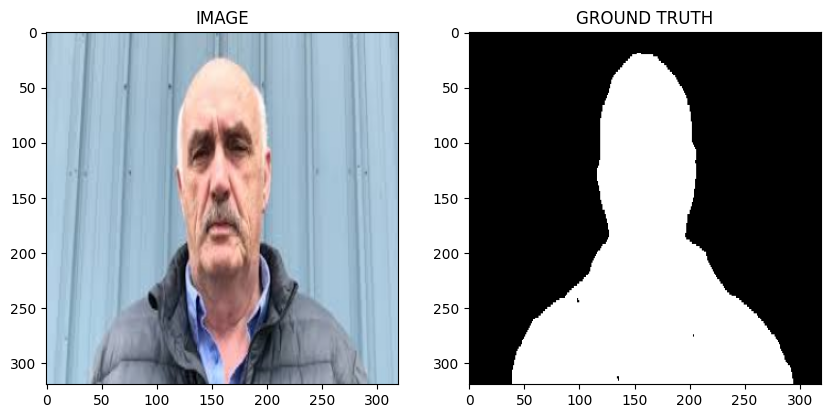

In [39]:
idx = 19

image, mask = trainset[idx]
helper.show_image(image, mask)

In [40]:
idx = 20
print(trainset[idx][0].shape)
print(trainset[idx][1].shape)

torch.Size([3, 320, 320])
torch.Size([1, 320, 320])


# Task 5 : Load dataset into batches

In [41]:
from torch.utils.data import DataLoader

In [42]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

print("Total no. of batches in trainloader: ", len(trainloader))
print("Total no. of batches in validloader: ", len(validloader))

Total no. of batches in trainloader:  5
Total no. of batches in validloader:  2


In [43]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentaion Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [44]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [45]:
class SegmentationModel(nn.Module):
  def __init__(self) -> None:
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels=3,
        classes= 1,
        activation=None
    )

  def forward(self, images, masks = None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [46]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 275MB/s]


In [47]:
model;

In [48]:
# I_added

# !pip install accelerate
# from accelerate import dispatch_model, infer_auto_device_map
# from accelerate.utils import get_balanced_memory

# max_memory = get_balanced_memory(
#     model,
#     max_memory=None,
#     no_split_module_classes=["GPTNeoXLayer", "GPTNeoXMLP"],
#     dtype='float16',
#     low_zero=False,
# )

# device_map = infer_auto_device_map(
#     model,
#     max_memory=max_memory,
#     no_split_module_classes=["GPTNeoXLayer", "GPTNeoXMLP"],
#     dtype='float16'
# )

# model = dispatch_model(model, device_map=device_map)

# Task 7 : Create Train and Validation Function

In [49]:
def train_fn(data_loader: DataLoader, model: SegmentationModel, optimizer):
  model.train()  #to use dropout and batch-norm
  total_loss = 0.0

  for images, mask in tqdm(data_loader):
    images = images.to(DEVICE)
    mask = mask.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, mask)
    loss.backward()   #gradinets computing
    optimizer.step()  #weights updating

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [50]:
def eval_fn(data_loader: DataLoader, model: SegmentationModel):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, mask in tqdm(data_loader):
      images = images.to(DEVICE)
      mask = mask.to(DEVICE)

      logits, loss = model(images, mask)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [51]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss = np.Inf
train_loss_history = []
valid_loss_history = []

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  train_loss_history.append(train_loss)
  valid_loss_history.append(valid_loss)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("MODEL-SAVED")
    best_valid_loss = valid_loss

  print(f"Epoch: {i+1}    Train_loss: {train_loss}    Valid_loss: {valid_loss}")

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
epochs = list(map(int, np.linspace(1,EPOCHS, EPOCHS)))
plt.plot(epochs, train_loss_history, 'b')
plt.plot(epochs, valid_loss_history, 'r')
plt.ylim(0, 2)

plt.title("Loss graphs during training")
plt.xlabel("Epochs")
plt.ylabel("Loss (DiceLoss + Binary Cross Entropy)")

plt.show()

# Task 9 : Inference

In [ ]:
idx = 10

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))  # (C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) *1.0
print(logits_mask)

In [ ]:
print(type(image))
print(image.shape)

In [ ]:
print(logits_mask.device)
print(logits_mask.shape)
print(logits_mask.squeeze(1).shape)
print(logits_mask.detach().cpu().device)

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya